In [72]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, chi2_contingency
import matplotlib.pyplot as plt
import pickle
#from Generic_Functions import model_fitting_and_get_training_accuracy, get_test_accuracy, clean_data, outlier_removal



In [51]:
test = pd.read_csv('C:/Deepak/IIM/Dataset/Test_Churn.csv')
train = pd.read_csv('C:/Deepak/IIM/Dataset/Train_Churn.csv')

target_distribution = train['Churn'].value_counts()

# Unique value counts of target variable
print(target_distribution)





 False.    2850
 True.      483
Name: Churn, dtype: int64


In [52]:
cat = ['state', 'area code', 'phone number', 'international plan', 'voice mail plan']

# ------------------------------------- Chi-square test for every categorical variable ---------------------------------

for i in cat:
    print(i)
    cross_tab = pd.crosstab(train[i], train['Churn'])
    chi2, p, dof, ex = chi2_contingency(cross_tab)
    print(p)


state
0.002296221552011188
area code
0.9150556960243712
phone number
0.49185608455943547
international plan
2.4931077033159556e-50
voice mail plan
5.15063965903898e-09


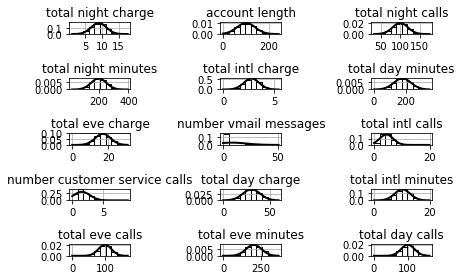

In [53]:
# -------------- Histogram of every numerical variable with Normal distribution curve superimposed over it -------------

num = list(set(train.columns) - set(cat+['Churn']))

fig = plt.figure()
for i, var_name in enumerate(num):
    mu, std = norm.fit(train[var_name])
    ax = fig.add_subplot(5, 3, i+1)
    train[var_name].hist(density=True, edgecolor='k', color='w', ax=ax)
    xmin, xmax = min(train[var_name]), max(train[var_name])
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.set_title(var_name)
fig.tight_layout()  # Reduces size of each plot to fit each variable name thereby improving the appearance
plt.show()

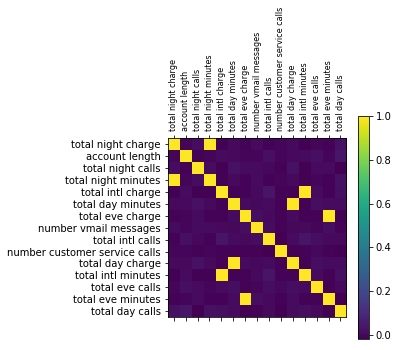

In [54]:
# ----------------------------------------- Correlation plot of numerical variables ------------------------------------

plt.matshow(train[num].corr())
plt.xticks(range(len(train[num].columns)), train[num].columns, fontsize=8, rotation=90)
plt.yticks(range(len(train[num].columns)), train[num].columns)
plt.colorbar()
plt.show()

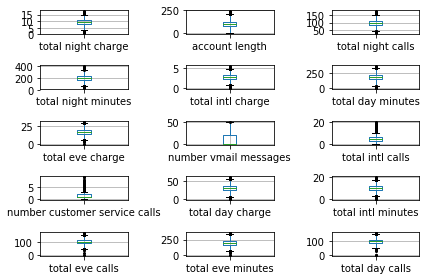

In [55]:
# ------------------------------------------ Box plot of every numerical variable --------------------------------------

fig = plt.figure()
for i, var_name in enumerate(num):
    ax = fig.add_subplot(5, 3, i+1)
    train.boxplot(column=var_name, ax=ax, flierprops=dict(marker='.', markerfacecolor='black', markersize=4))
fig.tight_layout()  # Reduces size of each plot to fit each variable name thereby improving the appearance
plt.show()

In [56]:
def clean_data(data, remove=None):
    cleansed_data = data.copy()
    cleansed_data = cleansed_data.drop(['state', 'phone number', 'area code'], axis=1)
    if remove == 'charges':
        cleansed_data = cleansed_data.drop(['total night charge', 'total day charge', 'total intl charge',
                                            'total eve charge'], axis=1)
    if remove == 'minutes':
        cleansed_data = cleansed_data.drop(['total night minutes', 'total day minutes', 'total intl minutes',
                                            'total eve minutes'], axis=1)
    le = LabelEncoder()
    cleansed_data['Churn'] = le.fit_transform(cleansed_data['Churn'])
    cleansed_data['international plan'] = le.fit_transform(cleansed_data['international plan'])
    cleansed_data['voice mail plan'] = le.fit_transform(cleansed_data['voice mail plan'])
    return cleansed_data

In [57]:
cat = ['state', 'area code', 'phone number', 'international plan', 'voice mail plan']
num = list(set(train.columns) - set(cat+['Churn']))

train = clean_data(train)
test = clean_data(test)


In [58]:
def outlier_removal(data, cols):
    for i in cols:
        print(i)
        q75, q25 = np.percentile(data.loc[:, i], [75, 25])
        iqr = q75-q25
        min_value = q25 - (1.5*iqr)
        max_value = q75 + (1.5*iqr)
        print(q75, q25, iqr, min_value,  max_value)
        data = data.drop(data[data.loc[:, i] < min_value].index)
        data = data.drop(data[data.loc[:, i] > max_value].index)
        print(data.shape[0])
    return data

In [59]:


# Dataset without any outliers
train = outlier_removal(train, num)




total night charge
10.59 7.52 3.0700000000000003 2.914999999999999 15.195
3303
account length
127.0 74.0 53.0 -5.5 206.5
3285
total night calls
113.0 87.0 26.0 48.0 152.0
3263
total night minutes
235.0 167.1 67.9 65.24999999999999 336.85
3263
total intl charge
3.27 2.3 0.9700000000000002 0.8449999999999995 4.7250000000000005
3216
total day minutes
216.45000000000002 143.775 72.67500000000001 34.76249999999999 325.46250000000003
3193
total eve charge
19.99 14.18 5.809999999999999 5.465000000000002 28.705
3169
number vmail messages
20.0 0.0 20.0 -30.0 50.0
3168
total intl calls
6.0 3.0 3.0 -1.5 10.5
3092
number customer service calls
2.0 1.0 1.0 -0.5 3.5
2838
total day charge
36.7475 24.485 12.262500000000003 6.091249999999995 55.14125000000001
2836
total intl minutes
12.1 8.6 3.5 3.3499999999999996 17.35
2834
total eve calls
113.0 87.0 26.0 48.0 152.0
2815
total eve minutes
235.2 167.2 68.0 65.19999999999999 337.2
2814
total day calls
114.0 87.0 27.0 46.5 154.5
2796


In [60]:

x_train = train.iloc[:, train.columns != 'Churn']
y_train = train.iloc[:, train.columns == 'Churn']
x_test = test.iloc[:, test.columns != 'Churn']
y_test = test.iloc[:, test.columns == 'Churn']

In [61]:
# --------------------------------- Normalizing data with mean 0 and variance 1 ----------------------------------------

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Deepak\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [79]:
def model_fitting_and_get_training_accuracy(model, x_train, y_train, **kwargs):

    classifier = model(**kwargs)

    classifier.fit(x_train, y_train)

    predictions_train = classifier.predict(x_train)

    predictions_train_prob = classifier.predict_proba(x_train)[:, 1]

    accuracy_train = accuracy_score(predictions_train, y_train)

    average_precision_train = average_precision_score(y_train, predictions_train_prob)

    return predictions_train, predictions_train_prob, round(accuracy_train, 3), classifier, \
        round(average_precision_train, 3)


In [80]:
def get_test_accuracy(x_test, classifier, y_test):

    predictions_test = classifier.predict(x_test)

    predictions_test_prob = classifier.predict_proba(x_test)[:, 1]

    accuracy_test = accuracy_score(predictions_test, y_test)

    average_precision_test = average_precision_score(y_test, predictions_test_prob)

    precision, recall, _ = precision_recall_curve(y_test, predictions_test_prob)

    return predictions_test, predictions_test_prob, round(accuracy_test, 3), round(average_precision_test, 3), \
        precision, recall

In [85]:
# --------------------------------------------- Logistic Regression ----------------------------------------------------

lr_predictions_train, lr_predictions_train_prob, lr_accuracy_train, lr_classifier, lr_average_precision_train = \
    model_fitting_and_get_training_accuracy(LogisticRegression, x_train, y_train, random_state=0)






C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
lr_predictions_test, lr_predictions_test_prob, lr_accuracy_test, lr_average_precision_test, lr_precision, lr_recall = \
    get_test_accuracy(x_test, lr_classifier, y_test)

In [87]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/LogisticRegression.sav'
pickle.dump(lr_classifier, open(filename, 'wb'))


In [88]:
# ------------------------------------------------- Naive Bayes --------------------------------------------------------

gnb_predictions_train, gnb_predictions_train_prob, gnb_accuracy_train, gnb_classifier, gnb_average_precision_train = \
    model_fitting_and_get_training_accuracy(GaussianNB, x_train, y_train)

gnb_predictions_test, gnb_predictions_test_prob, gnb_accuracy_test, gnb_average_precision_test, gnb_precision, \
    gnb_recall = get_test_accuracy(x_test, gnb_classifier, y_test)



C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/NaiveBayes.sav'
pickle.dump(gnb_classifier, open(filename, 'wb'))

In [65]:
# -------------------------------------------- Support Vector Machine --------------------------------------------------

svm_predictions_train, svm_predictions_train_prob, svm_accuracy_train, svm_classifier, svm_average_precision_train = \
    model_fitting_and_get_training_accuracy(SVC, x_train, y_train, probability=True, random_state=0)

svm_predictions_test, svm_predictions_test_prob, svm_accuracy_test, svm_average_precision_test, svm_precision, \
    svm_recall = get_test_accuracy(x_test, svm_classifier, y_test)



C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/SVM.sav'
pickle.dump(svm_classifier, open(filename, 'wb'))

In [66]:
# -------------------------------------------- Gradient Boosted Tree ---------------------------------------------------

gbc_predictions_train, gbc_predictions_train_prob, gbc_accuracy_train, gbc_classifier, gbc_average_precision_train = \
    model_fitting_and_get_training_accuracy(GradientBoostingClassifier, x_train, y_train, max_depth=2, random_state=0)

gbc_predictions_test, gbc_predictions_test_prob, gbc_accuracy_test, gbc_average_precision_test, gbc_precision, \
    gbc_recall = get_test_accuracy(x_test, gbc_classifier, y_test)



C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/GBoosting.sav'
pickle.dump(gbc_classifier, open(filename, 'wb'))

In [92]:
# ------------------------------------------------ Decision Tree -------------------------------------------------------

dtc_predictions_train, dtc_predictions_train_prob, dtc_accuracy_train, dtc_classifier, dtc_average_precision_train = \
    model_fitting_and_get_training_accuracy(DecisionTreeClassifier, x_train, y_train, min_impurity_decrease=0.01,
                                            criterion='entropy', random_state=0)

dtc_predictions_test, dtc_predictions_test_prob, dtc_accuracy_test, dtc_average_precision_test, dtc_precision, \
    dtc_recall = get_test_accuracy(x_test, dtc_classifier, y_test)



In [93]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/DecisionTree.sav'
pickle.dump(dtc_classifier, open(filename, 'wb'))

In [94]:
# ------------------------------------------------ Random Forest -------------------------------------------------------

rf_predictions_train, rf_predictions_train_prob, rf_accuracy_train, rf_classifier, rf_average_precision_train = \
    model_fitting_and_get_training_accuracy(RandomForestClassifier, x_train, y_train, n_estimators=500, random_state=0)

rf_predictions_test, rf_predictions_test_prob, rf_accuracy_test, rf_average_precision_test, rf_precision, rf_recall = \
    get_test_accuracy(x_test, rf_classifier, y_test)



C:\Users\Deepak\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [95]:
# save the model to disk
filename = 'C:/Deepak/IIM/result/RandomForest.sav'
pickle.dump(rf_classifier, open(filename, 'wb'))

C:\Users\Deepak\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


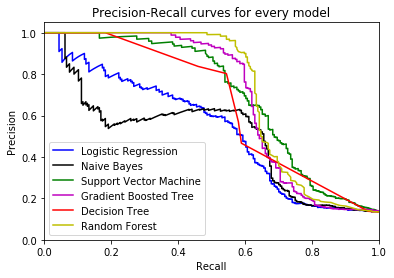

In [96]:
# ------------------------------------ Precision Recall Curves of each model -------------------------------------------

plt.plot(lr_recall, lr_precision, color='b', label='Logistic Regression')
plt.plot(gnb_recall, gnb_precision, color='k', label='Naive Bayes')
plt.plot(svm_recall, svm_precision, color='g', label='Support Vector Machine')
plt.plot(gbc_recall, gbc_precision, color='m', label='Gradient Boosted Tree')
plt.plot(dtc_recall, dtc_precision, color='r', label='Decision Tree')
plt.plot(rf_recall, rf_precision, color='y', label='Random Forest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1])
plt.title('Precision-Recall curves for every model')
plt.legend(loc='bottom left')
plt.show()



In [97]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9358128374325135


In [98]:
# ----------------------------------- Write the predictions in a csv file with features used ---------------------------

test['rf_predictions_test'] = rf_predictions_test
test.to_csv('C:/Deepak/IIM/result/Churn_with_predictions.csv', index=False)



In [99]:
# ----------------------------------------- Print performance metrics of the best model --------------------------------

print('Training set accuracy of the best model i.e. Random Forest is : ', rf_accuracy_train)
print('Test set accuracy of the best model i.e. Random Forest is : ', rf_accuracy_test)
print('Average precision score of the best model i.e. Random Forest on training set is : ', rf_average_precision_train)
print('Average precision score of the best model i.e. Random Forest on test set is : ', rf_average_precision_test)

# ----------------------------------------------------- End ------------------------------------------------------------


Training set accuracy of the best model i.e. Random Forest is :  1.0
Test set accuracy of the best model i.e. Random Forest is :  0.936
Average precision score of the best model i.e. Random Forest on training set is :  1.0
Average precision score of the best model i.e. Random Forest on test set is :  0.714
